In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, applications, Model
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python.client import device_lib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/JapanZernike"
import sys
sys.path.append('/content/drive/My Drive/JapanZernike')

In [ ]:
#print(tf.__version__)
!pip show tensorflow  # 1.6.0
!ls "/content/drive/My Drive/JapanZernike"
!ls "/content/drive"

In [ ]:
import random

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


In [ ]:
labels_df = pd.read_csv('drive/My Drive/JapanZernike/Dzyuba/csvfile.csv', sep=',', header=None)
print(labels_df.head())
columns = np.delete(np.array(labels_df.columns), 0)
len(labels_df)
print(columns.shape)

                                           0     1    2  ...    6    7    8
0  n4m0/_n4m0a0.10_n1m1a0.05_z500_intens.png  0.05  0.0  ...  0.1  0.0  0.0
1  n4m0/_n4m0a0.10_n1m1a0.10_z500_intens.png  0.10  0.0  ...  0.1  0.0  0.0
2  n4m0/_n4m0a0.10_n1m1a0.15_z500_intens.png  0.15  0.0  ...  0.1  0.0  0.0
3  n4m0/_n4m0a0.10_n1m1a0.20_z500_intens.png  0.20  0.0  ...  0.1  0.0  0.0
4  n4m0/_n4m0a0.10_n1m1a0.25_z500_intens.png  0.25  0.0  ...  0.1  0.0  0.0

[5 rows x 9 columns]
(8,)


In [ ]:
datagen=ImageDataGenerator(rescale=1./255)
#datagen=ImageDataGenerator(rescale=1./255, rotation_range=45)  # Augmentation by rotation in range 0-45 deg
#datagen=ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)  # Augmentation by noising

data_len = len(labels_df)
train_data_len = int(0.8*data_len)
test_data_len = int(0.2*data_len)
print(train_data_len)
print(test_data_len)

shuffled_data = shuffle(labels_df)
batch_size = 10

train_generator=datagen.flow_from_dataframe(
dataframe=shuffled_data[:train_data_len],
directory="drive/My Drive/JapanZernike/Dzyuba/data",
#directory="drive/My Drive/JapanZernike/magistracy/plots",
#directory="drive/Shared with me/magistracy/plots",
x_col=0,
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(299,299))

test_generator=datagen.flow_from_dataframe(
dataframe=shuffled_data[train_data_len:],
directory="drive/My Drive/JapanZernike/Dzyuba/data",
x_col=0,
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(299,299))

1539
384
Found 1539 validated image filenames.
Found 385 validated image filenames.


10 (299, 299, 3)
(8,) [0.  0.  0.1 0.  0.  0.  0.  0.2]


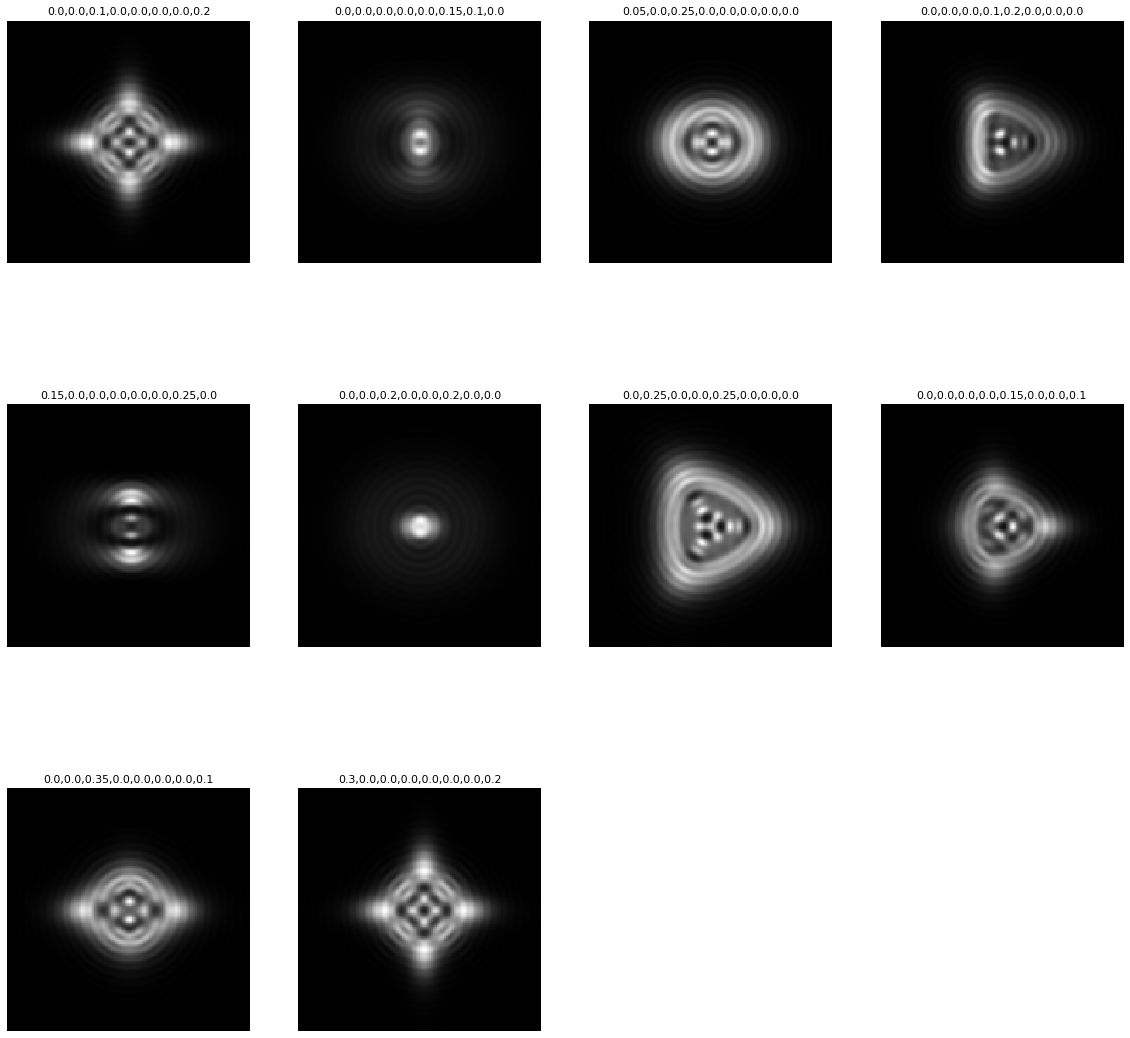

In [ ]:
import matplotlib.pyplot as plt

(x, y) = train_generator.next()
print(len(x), x[0].shape)
print(y[0].shape, y[0])

plt.figure(figsize=(20, 20))
for i, images in enumerate(x):  #train_generator.take(1):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(images)
  y_str = ','.join(str(x) for x in y[i])
  plt.title(y_str, fontsize=11)
  plt.axis("off")


In [ ]:
model = keras.applications.xception.Xception(include_top=True, weights=None, input_tensor=None, input_shape=None, pooling=None)  #, classes=200)


In [ ]:
x = keras.layers.Dropout(0.2)(model.output)
predictions = keras.layers.Dense(len(columns), activation='linear')(x)
print(predictions.shape)

(None, 8)


In [ ]:
my_model = keras.models.Model(inputs = model.input, outputs = predictions)

In [ ]:
INIT_LR = 1e-4  #1e-
EPOCHS = 200

opt = keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#my_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
my_model.compile(optimizer=opt, loss='mae', metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Custom class for real-time loss graph during training

In [ ]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses1 = PlotLosses()


In [ ]:
history = my_model.fit_generator(generator=train_generator, 
                    validation_data=test_generator, 
                    steps_per_epoch=train_data_len // batch_size,
                    validation_steps=test_data_len // batch_size,
                    epochs=EPOCHS,
                    callbacks=[plot_losses1],
                    verbose=1
                    )

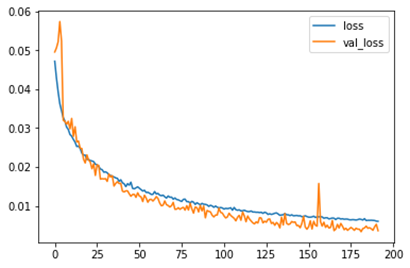

In [ ]:
predict_generator=datagen.flow_from_dataframe(
dataframe=shuffled_data[train_data_len:],
directory="drive/My Drive/JapanZernike/Dzyuba/data",
x_col=0,
y_col=columns,
batch_size=1,
seed = 10, #8,  #15,  #11,  #43,
shuffle=True,
class_mode="raw",
target_size=(299,299))

#my_model.summary()
X,y = predict_generator.next()
pred = my_model.predict(X)
print(y)
print(pred)


Found 385 validated image filenames.
[[0.  0.  0.1 0.4 0.  0.  0.  0. ]]
[[-1.0653329e-04 -8.4491214e-05  1.0230997e-01  3.5768172e-01
  -1.4419015e-04  1.9694766e-04  3.0161010e-04  7.2757481e-05]]
